#Description of the NoteBook

Students:
- Teka Kimbi Ntimanputu (10673197)
- William Stucchi (10661711)
- Lorenzo Veronese (10654901)

This notebook represents one of the initial steps in utilizing transfer learning and fine-tuning techniques, employing the pre-trained ResNet50 network.

#Flags

List of flags to enable and disable some parts of the notebook

In [1]:
CREATE_FOLDERS_ON_DRIVE=False

#Install keras CV

In [2]:
!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 49.1 MB/s eta 0:00:00


# Import libraries

In [3]:
#Connect to drive
from google.colab import drive

In [4]:
from numpy import load
import numpy as np
from google.colab.patches import cv2_imshow
from PIL import Image, ImageOps
import os

In [5]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [6]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers
from keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [7]:
# Import other libraries
import cv2
import keras_cv
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import math

Using TensorFlow backend


In [8]:
drive.mount('/gdrive')
%cd /gdrive/My Drive/ChallengeAN2DL/Homework1

Mounted at /gdrive
/gdrive/My Drive/ChallengeAN2DL/Homework1


# Loading dataset


In the following lines of code the dataset is loaded and divided into an image set and a label set

In [9]:
#load data
data = load('public_data.npz', allow_pickle=True)
lst = data.files

In [10]:
#Divide the dataset in image set and label set
img_set = data['data']
label_set = data['labels']


In [11]:
#Inspect the shape and the type
print(data['data'][0].shape)
print(type(data['data'][0]))

(96, 96, 3)
<class 'numpy.ndarray'>


#Inspect Data

The dataset is displayed in order to perform an initial inspection on the data, allowing to underatand its content

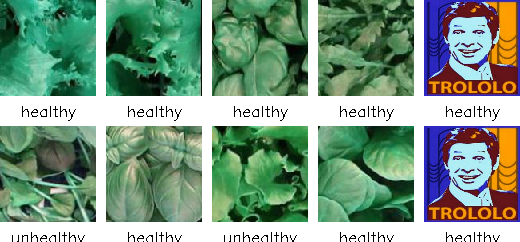

In [12]:
# Calculate the canvas size based on image and label dimensions
num_images = len(img_set)
num_to_display = 10
vertical_spacing = 10
horizontal_spacing = 10

max_image_height = max(img.shape[0] for img in img_set)
image_width = img_set[0].shape[1]
label_height = 20
canvas_height = 2 * (max_image_height + label_height) + vertical_spacing
canvas_width = 5 * image_width + 4 * horizontal_spacing
canvas = np.ones((canvas_height, canvas_width, 3), dtype=np.uint8) * 255
random_indices = random.sample(range(num_images), num_to_display)

# Arrange and display the images and labels with spacing
for i, index in enumerate(random_indices):
    row = i // 5
    col = i % 5
    y_offset = row * (max_image_height + label_height + vertical_spacing)
    x_offset = col * (image_width + horizontal_spacing)

    img = img_set[index]
    canvas[y_offset:y_offset + img.shape[0], x_offset:x_offset + image_width, :] = img

    label_text = label_set[index]
    label_size, _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    label_x = x_offset + (image_width - label_size[0]) // 2
    label_y = y_offset + img.shape[0] + label_height
    cv2.putText(canvas, label_text, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

cv2_imshow(canvas)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Data Cleaning

Due to the presence of evident outliers within the dataset, a data cleaning operation was conducted to prepare the the data splitting phase and subsequent training phase.

## Shrek

In [13]:
# reference image 'shrek'
shrek = img_set[58]

# List to store the indexes of images to remove
indexes_to_remove = []

# Iterate through the image set to identify occurrences of 'shrek'
for i in range(0, len(img_set)):
    if np.array_equal(shrek, img_set[i]):
        indexes_to_remove.append(i)

print("Indexes to remove:", indexes_to_remove)
print("Number of indexes to remove:", len(indexes_to_remove))

Indexes to remove: [58, 95, 137, 138, 171, 207, 506, 571, 599, 622, 658, 692, 779, 827, 840, 880, 901, 974, 1028, 1265, 1268, 1280, 1333, 1443, 1466, 1483, 1528, 1554, 1594, 1651, 1806, 1866, 1938, 1977, 2022, 2081, 2090, 2261, 2311, 2328, 2380, 2435, 2451, 2453, 2515, 2663, 2665, 2675, 2727, 2734, 2736, 2755, 2779, 2800, 2830, 2864, 2866, 2913, 2937, 3033, 3055, 3105, 3144, 3155, 3286, 3410, 3488, 3572, 3583, 3666, 3688, 3770, 3801, 3802, 3806, 3811, 3862, 3885, 3927, 3931, 3946, 3988, 4097, 4118, 4144, 4150, 4282, 4368, 4475, 4476, 4507, 4694, 4740, 4779, 4857, 5082, 5121, 5171]
Number of indexes to remove: 98


In [14]:
print("Length before removing Shrek: ", len(img_set))

#Remove the images and the labels related to the outliers
img_set = img_set[~np.isin(np.arange(len(img_set)), indexes_to_remove)]
label_set = label_set[~np.isin(np.arange(len(label_set)), indexes_to_remove)]

print("Length after removing Shrek: ", len(img_set))

Length before removing Shrek:  5200
Length after removing Shrek:  5102


## Trololo

In [15]:
# Reference image 'trololo' from the image set
trololo = img_set[332]  # Note: It is 332 AFTER removing 'Shrek'

# List to store the indexes of images to remove
indexes_to_remove = []

# Iterate through the image set to identify occurrences of 'trololo'
for i in range(0, len(img_set)):
    if np.array_equal(trololo, img_set[i]):
         indexes_to_remove.append(i)

print("Indexes to remove:", indexes_to_remove)
print("Number of indexes to remove:", len(indexes_to_remove))

Indexes to remove: [332, 406, 428, 480, 522, 689, 711, 713, 741, 770, 882, 944, 954, 971, 1025, 1045, 1046, 1082, 1130, 1153, 1171, 1172, 1361, 1514, 1580, 1601, 1660, 1667, 1722, 1727, 1729, 1797, 1871, 1906, 1947, 1954, 2113, 2154, 2155, 2161, 2308, 2385, 2443, 2452, 2519, 2536, 2548, 2551, 2628, 2743, 2776, 2784, 2832, 2871, 2989, 3025, 3046, 3311, 3370, 3385, 3423, 3629, 3669, 3728, 3745, 3759, 3818, 3821, 3826, 3869, 3883, 3907, 3967, 3973, 4017, 4223, 4227, 4229, 4323, 4413, 4466, 4514, 4527, 4627, 4643, 4673, 4743, 4754, 4765, 4788, 4802, 4808, 4812, 4832, 4953, 4985, 5046, 5068]
Number of indexes to remove: 98


In [16]:

print("Length before removing Trololo: ", len(img_set))

#Remove the images and the labels related to the outliers
img_set = img_set[~np.isin(np.arange(len(img_set)), indexes_to_remove)]
label_set = label_set[~np.isin(np.arange(len(label_set)), indexes_to_remove)]

print("Length after removing Trololo: ", len(img_set))

Length before removing Trololo:  5102
Length after removing Trololo:  5004


# Distributions

The data distribution across different classes was visualized using a histogram

In [17]:
# Create a list of unique classes in your label set
unique_classes = np.unique(label_set)
# Count the occurrences of each class
class_counts = [np.sum(label_set == c) for c in unique_classes]
# Number of bins,bar width, separation between bars and their position
n_bins = len(unique_classes)
bar_width = 0.4
bar_spacing = 0.2
x_positions = np.arange(len(unique_classes))
colors = ['green', 'brown']

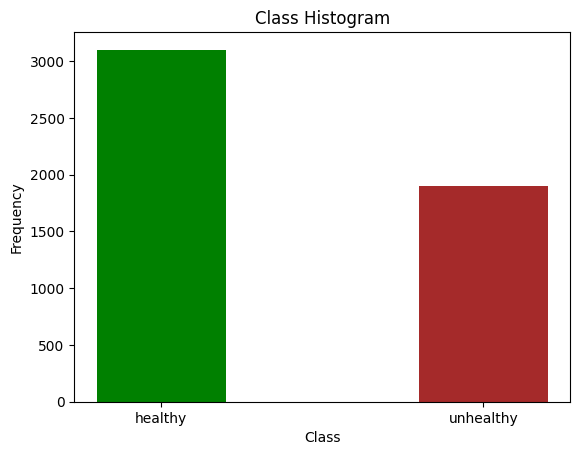

In [18]:
plt.bar(x_positions, class_counts, width=bar_width, color=colors)
plt.xticks(x_positions, unique_classes)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Histogram')
plt.show()

#Create dataset folder


Using the previously loaded dataset, the images are stored in separate folders on the drive , categorized according to their recpective classes

In [19]:
if CREATE_FOLDERS_ON_DRIVE:
  # Mapping from label strings to numerical values
  labels_string_to_num = {'healthy': 0, 'unhealthy': 1}

  # Replace label strings with their corresponding numerical values
  for i in range(0, len(label_set)):
      label_set[i] = labels_string_to_num[label_set[i]]

  # Define the paths for saving images
  output_folder_0 = "data/healthy"
  output_folder_1 = "data/unhealthy"

  # Create the output folders if they don't exist
  os.makedirs(output_folder_0, exist_ok=True)
  os.makedirs(output_folder_1, exist_ok=True)

  # Iterate through the images and labels
  for i, (img, label) in enumerate(zip(img_set, label_set)):
      img_pil = Image.fromarray(img.astype(np.uint8))
      if label == 0:
          output_folder = output_folder_0
      elif label == 1:
          output_folder = output_folder_1
      else:
          continue

      # Save the image
      img_filename = f"image_{i}.jpg"
      img_path = os.path.join(output_folder, img_filename)
      img_pil.save(img_path)

      print(f"Saved {img_filename} to {output_folder}")

#Training and validation set

The dataset stored on drive is splitted into training and validation set

In [20]:
# Define constants for dataset and image settings
VALIDATION_SPLIT = 0.15
BATCH_SIZE = 64
IMAGE_SIZE = (96,96)
IMAGE_SHAPE = IMAGE_SIZE+(3,)
NUM_CLASSES = 2
DIR = 'data'
# Create a training dataset using image data from the specified directory
train_set = tf.keras.utils.image_dataset_from_directory(
    DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    shuffle=True,
    seed=seed,
    validation_split=VALIDATION_SPLIT,
    subset='training'
)
# Create a validation dataset using image data from the specified directory
val_set = tf.keras.utils.image_dataset_from_directory(
    DIR,
    labels='inferred',
    label_mode='categorical',
    class_names= None,
    color_mode='rgb',
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    shuffle=True,
    seed=seed,
    validation_split=VALIDATION_SPLIT,
    subset='validation'
)


Found 5004 files belonging to 2 classes.
Using 4254 files for training.
Found 5004 files belonging to 2 classes.
Using 750 files for validation.


#Random augmentation

Images are prepared to undergo to the data augmentation process in accordance with the recommended practices detailed in the [keras documentation](https://keras.io/api/layers/preprocessing_layers/image_augmentation/).The images can possibly undergo to the following augmentation processes:


*   Random Zoom
*   Random Rotation
*   Random Flip  



In [21]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(height_factor=-0.15)
],name='data_aug')

#Class weights

To counteract imbalanced datasets, the approach of class weights is adopted,
wherein differents weights are allocated to classes determined by their frequencies within the dataset.

In [22]:
# Scaling by total/2 helps keep the loss to a similar magnitude.

# Paths to classes' folders
healthy_path = "data/healthy"
unhealthy_path = "data/unhealthy"

# Get a list of all items (files and subfolders) in the folder
healthy_items = os.listdir(healthy_path)
unhealthy_items = os.listdir(unhealthy_path)


# Count the number of items
num_healthy = len(healthy_items)
num_unhealthy = len(unhealthy_items)

print(f"There are {num_healthy} healthy and {num_unhealthy} unhealthy")


# Total number of samples
total = num_healthy + num_unhealthy

# Calculate class weights for binary classification
# Class weight for 0 (healthy)
weight_for_0 = (1 / num_healthy) * (total / 2.0)
# Class weight for 1 (unhealthy)
weight_for_1 = (1 / num_unhealthy) * (total / 2.0)

# Create a dictionary that maps class labels to their corresponding class weights
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 (healthy): {:.2f}'.format(weight_for_0))
print('Weight for class 1 (unhealthy): {:.2f}'.format(weight_for_1))

There are 3101 healthy and 1903 unhealthy
Weight for class 0 (healthy): 0.81
Weight for class 1 (unhealthy): 1.31


#Transfer Learning

Pre-trained model to perform transfer learning

##Model

Instantiation of a ResNet50 model using TensorFlow's Keras library

In [23]:
resNet= tf.keras.applications.resnet50.ResNet50(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet',
    pooling = 'avg'
)

94765736/94765736 [==============================] - 5s 0us/step


All the layers of the network are freezed

In [24]:
for layer in resNet.layers:
  layer.trainable = False

Definition of the neural network model using TensorFlow's Keras API

In [25]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=IMAGE_SHAPE, name="input_layer"),
    data_augmentation,
    tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input),
    resNet,
    #tf.keras.layers.Flatten(), it's not necessary in this case
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', kernel_initializer=tf.keras.initializers.GlorotUniform(seed), name='output_layer')
], name = "resNet50")

In [26]:
model.summary()

Model: "resNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_aug (Sequential)       (None, 96, 96, 3)         0         
                                                                 
 lambda (Lambda)             (None, 96, 96, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 output_layer (Dense)        (None, 2)                 1026      
                                                                 
Total params: 24637826 (93.99 MB)
Trainable params: 105011

In [27]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy()
,
    metrics=['accuracy']
    )


##Train

Train the model with early stopping

In [28]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, mode='auto'),
]
# Train the model
history = model.fit(
    x = train_set,
    epochs = 200,
    batch_size= BATCH_SIZE,
    validation_data = val_set,
    callbacks = callbacks,
    class_weight=class_weight
).history

Epoch 1/200
67/67 [==============================] - 1023s 13s/step - loss: 0.9257 - accuracy: 0.5987 - val_loss: 0.5063 - val_accuracy: 0.7587
Epoch 2/200
67/67 [==============================] - 8s 110ms/step - loss: 0.6408 - accuracy: 0.7038 - val_loss: 0.4652 - val_accuracy: 0.7800
Epoch 3/200
67/67 [==============================] - 6s 88ms/step - loss: 0.5727 - accuracy: 0.7278 - val_loss: 0.4375 - val_accuracy: 0.7960
Epoch 4/200
67/67 [==============================] - 7s 104ms/step - loss: 0.5222 - accuracy: 0.7513 - val_loss: 0.4325 - val_accuracy: 0.7947
Epoch 5/200
67/67 [==============================] - 7s 93ms/step - loss: 0.4919 - accuracy: 0.7558 - val_loss: 0.4139 - val_accuracy: 0.8000
Epoch 6/200
67/67 [==============================] - 6s 87ms/step - loss: 0.4787 - accuracy: 0.7774 - val_loss: 0.4128 - val_accuracy: 0.8200
Epoch 7/200
67/67 [==============================] - 8s 109ms/step - loss: 0.4551 - accuracy: 0.7835 - val_loss: 0.4086 - val_accuracy: 0.8107
E

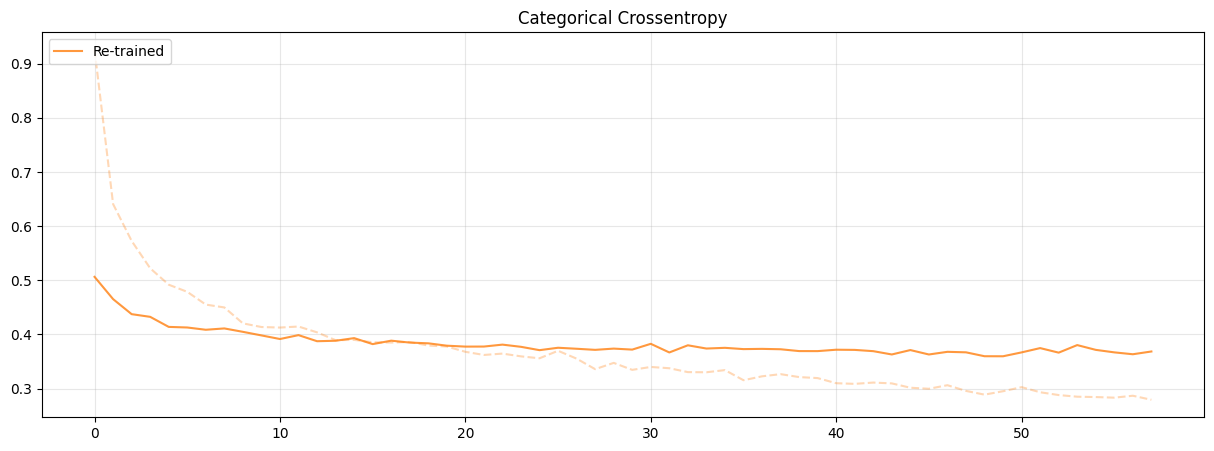

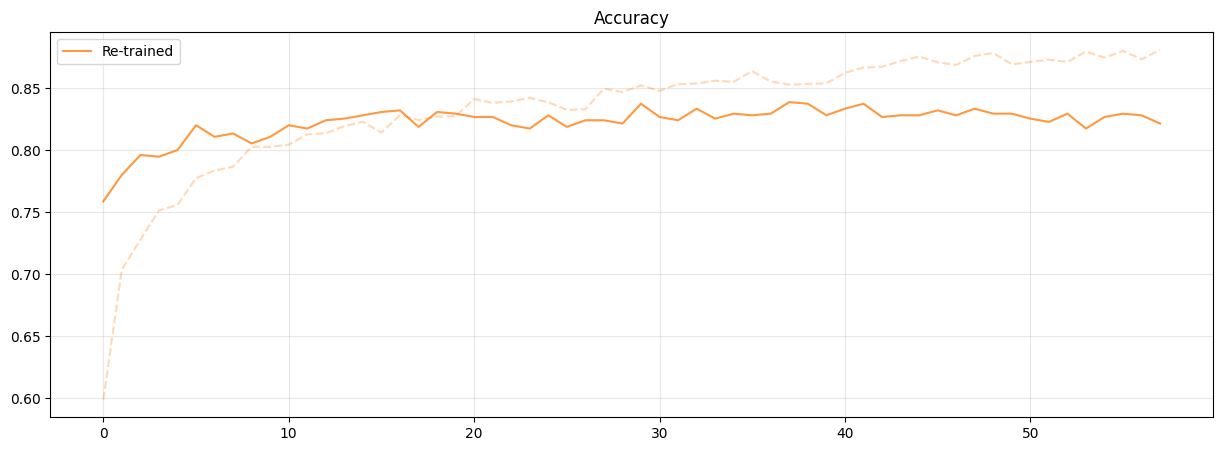

In [29]:
# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

#Fine-Tuning

The model is re-loaded for the fine-tuning process, during which layers are unfrozen to compute new weights tailored to the new task requiremennts

##Unfreeze layers

In [30]:
model.trainable = False
model.summary()

Model: "resNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_aug (Sequential)       (None, 96, 96, 3)         0         
                                                                 
 lambda (Lambda)             (None, 96, 96, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 output_layer (Dense)        (None, 2)                 1026      
                                                                 
Total params: 24637826 (93.99 MB)
Trainable params: 0 (0.0

###Last 100

In [31]:
# Set layers as non-trainable
for layer in model.layers[:-100]:
    layer.trainable = False

# Set the last 100 layers as trainable
for layer in model.layers[-100:]:
    layer.trainable = True


##Train

Train the model with early stopping

In [32]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate,weight_decay=5e-2),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [33]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, mode='auto'),
]
# Train the model
history_unfreeze = model.fit(
    x = train_set,
    epochs = 200,
    batch_size= BATCH_SIZE,
    validation_data = val_set,
    callbacks = callbacks,
    class_weight=class_weight
).history

Epoch 1/200
67/67 [==============================] - 13s 116ms/step - loss: 0.8572 - accuracy: 0.5759 - val_loss: 0.4556 - val_accuracy: 0.7893
Epoch 2/200
67/67 [==============================] - 6s 91ms/step - loss: 0.8474 - accuracy: 0.5867 - val_loss: 0.6150 - val_accuracy: 0.7147
Epoch 3/200
67/67 [==============================] - 6s 86ms/step - loss: 0.8647 - accuracy: 0.5764 - val_loss: 0.7608 - val_accuracy: 0.6480
Epoch 4/200
67/67 [==============================] - 7s 98ms/step - loss: 0.8596 - accuracy: 0.5736 - val_loss: 0.8308 - val_accuracy: 0.6293
Epoch 5/200
67/67 [==============================] - 6s 87ms/step - loss: 0.8546 - accuracy: 0.5806 - val_loss: 0.8652 - val_accuracy: 0.6160
Epoch 6/200
67/67 [==============================] - 8s 112ms/step - loss: 0.8568 - accuracy: 0.5757 - val_loss: 0.8847 - val_accuracy: 0.6067
Epoch 7/200
67/67 [==============================] - 6s 87ms/step - loss: 0.8502 - accuracy: 0.5771 - val_loss: 0.8929 - val_accuracy: 0.5960
Epo

#Save model

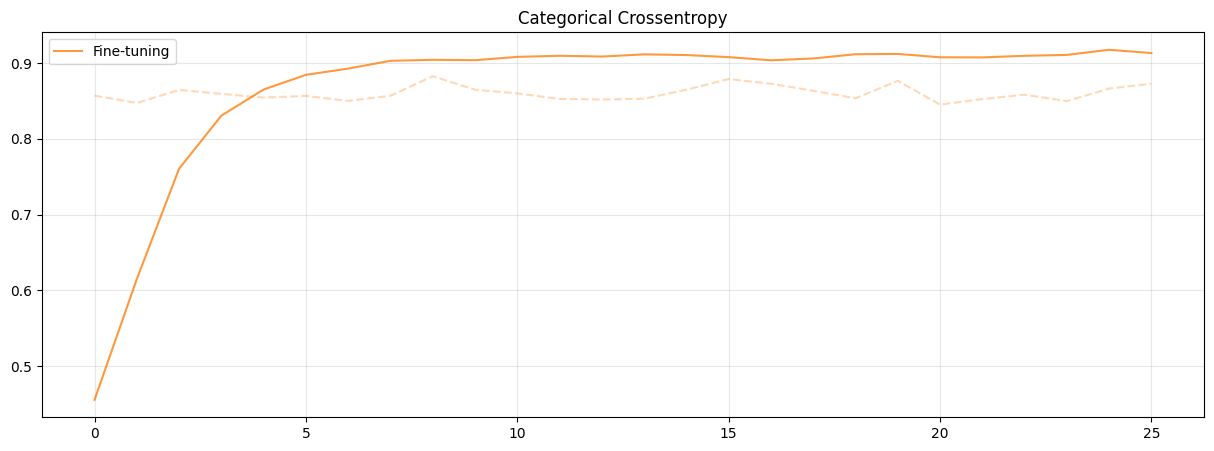

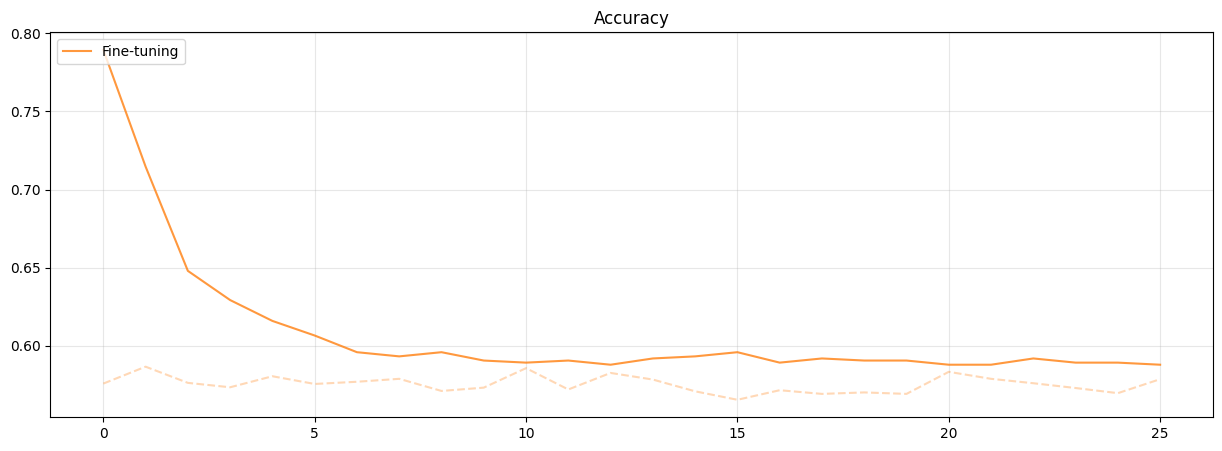

In [34]:
plt.figure(figsize=(15,5))
plt.plot(history_unfreeze['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history_unfreeze['val_loss'], label='Fine-tuning', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history_unfreeze['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history_unfreeze['val_accuracy'], label='Fine-tuning', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [35]:
from datetime import datetime

current_time = datetime.now()
current_hour = current_time.hour
current_minutes = current_time.minute
model.save("fine_tuning_ResNet_50" + str(current_hour) + "_" + str(current_minutes))
del model